In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize R^2 score dictionary
r2_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

mae_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

valid_target_properties = []

In [38]:
# target_property_list = ['voltage', 'energy', 'conductivity', 'columbic_efficiency']
target_property_list = ['voltage', 'energy', 'conductivity', 'capacity', 'columbic_efficiency']

In [39]:
gnn_data = pd.read_csv(f'data/data0.csv')

## Train Models

In [ ]:
## Evaluate with a set aside test set 

# Main loop
for target_property in target_property_list:
    try:
        df1 = pd.read_excel(f'data/{target_property}.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores[name].append(r2)

        mae = mean_absolute_error(y_test, y_pred)
        mae_scores[name].append(mae)

        print(f"{name} R² for {target_property}: {r2:.4f}")


Linear Regression R² for voltage: -0.8413
MLP Regressor R² for voltage: 0.4263
Random Forest Regressor R² for voltage: 0.7345
KNN Regressor R² for voltage: 0.6180
Decision Tree Regressor R² for voltage: 0.6461
Linear Regression R² for energy: -20.2448
MLP Regressor R² for energy: -5.9683
Random Forest Regressor R² for energy: -1.9512
KNN Regressor R² for energy: 0.3180
Decision Tree Regressor R² for energy: -9.6368
Linear Regression R² for conductivity: -113222.3899
MLP Regressor R² for conductivity: -13588.8513
Random Forest Regressor R² for conductivity: -150875.5033
KNN Regressor R² for conductivity: -90390.3019
Decision Tree Regressor R² for conductivity: -4854.5360
Linear Regression R² for capacity: 0.0222
MLP Regressor R² for capacity: 0.7015
Random Forest Regressor R² for capacity: 0.1456
KNN Regressor R² for capacity: -0.3216
Decision Tree Regressor R² for capacity: -3.1370
Linear Regression R² for columbic_efficiency: -2.3236
MLP Regressor R² for columbic_efficiency: -4.6719
R

In [ ]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

for target_property in target_property_list:
    print(f"STARTING PROPERTY {target_property.upper()}")
    try:
        df1 = pd.read_excel(f'data/{target_property}.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        print(f"Starting model {name}")
        fold_r2_accuracies = [] 
        fold_mae_accuracies = [] 

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            fold_r2_accuracies.append(r2)

            mae = mean_absolute_error(y_test, y_pred)
            fold_mae_accuracies.append(mae)

            # print(f"Completed fold {fold} with MAE {mae}")

        mae_scores[name].append(np.average(fold_mae_accuracies))
        r2_scores[name].append(np.average(fold_r2_accuracies))

        print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")

        # print(f"{name} R² for {target_property}: {r2:.4f}")

STARTING PROPERTY VOLTAGE
Starting model Linear Regression
Finished property Linear Regression with average MAE 1.5955309325394293
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 0.678297093808721
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 0.5996656964876336
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 0.6238891551607797
Starting model Decision Tree Regressor
Finished property Decision Tree Regressor with average MAE 0.8662967456691517
STARTING PROPERTY ENERGY
Starting model Linear Regression
Finished property Linear Regression with average MAE 883.2180330738399
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 517.9515196454038
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 458.80581779538
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 438.8696224806172
Startin

In [50]:
mae_scores

{'Linear Regression': [1.5955309325394293,
  883.2180330738399,
  5.550326273977478,
  440.9942775673553,
  17.30059831730769],
 'MLP Regressor': [0.678297093808721,
  517.9515196454038,
  3.6546112553715924,
  245.02487864399527,
  17.964308447234043],
 'Random Forest Regressor': [0.5996656964876336,
  458.80581779538,
  3.257638355129324,
  242.89344204982882,
  12.235165742865325],
 'KNN Regressor': [0.6238891551607797,
  438.8696224806172,
  2.5643599210671866,
  239.03476384510623,
  12.452929054939636],
 'Decision Tree Regressor': [0.8662967456691517,
  665.0937519382569,
  4.226100763903528,
  357.95986155676474,
  17.513581384492973]}

## Plot Final Scores

Use mae_scores or r2_scores to pick a metric

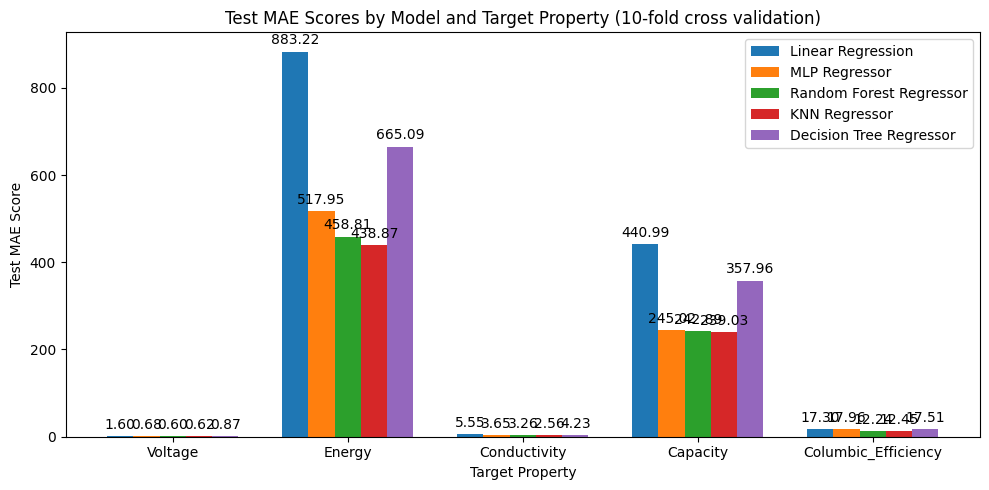

In [ ]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores(scores)
    rects_visible = ax.bar(x + offset, visible, width, label=label, color=color)

    # Draw hatched rectangles for invalid scores at fixed height
    hatch_height = 0.05  # fixed height for placeholder
    for i, invalid in enumerate(is_invalid):
        if invalid:
            ax.bar(x[i] + offset, hatch_height, width,
                   fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Test MAE Scores by Model and Target Property (10-fold cross validation)')
ax.set_xticks(x)
ax.set_xticklabels([prop.title() for prop in target_property_list], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()


[0 1 2 3 4] -0.3 [1.5955309325394293] 0.15 Linear Regression tab:blue
<BarContainer object of 1 artists>
[0 1 2 3 4] -0.15 [0.678297093808721] 0.15 MLP Regressor tab:orange
<BarContainer object of 1 artists>
[0 1 2 3 4] 0 [0.5996656964876336] 0.15 Random Forest Regressor tab:green
<BarContainer object of 1 artists>
[0 1 2 3 4] 0.15 [0.6238891551607797] 0.15 KNN Regressor tab:red
<BarContainer object of 1 artists>
[0 1 2 3 4] 0.3 [0.8662967456691517] 0.15 Decision Tree Regressor tab:purple
<BarContainer object of 1 artists>


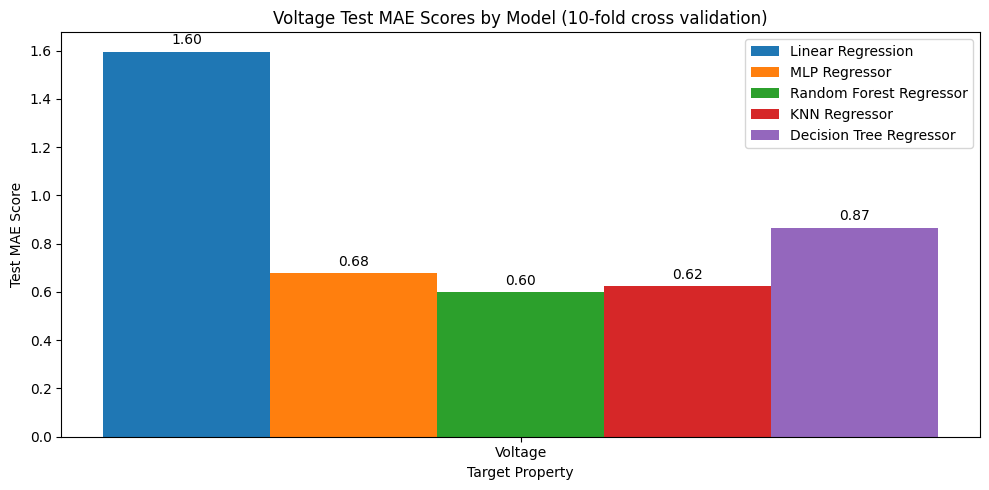

In [53]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores([scores[0]])
    rects_visible = ax.bar(x[0] + offset, visible, width, label=label, color=color)
    print(x, offset, visible, width, label, color)
    print(rects_visible)

    # Draw hatched rectangles for invalid scores at fixed height
    # hatch_height = 0.05  # fixed height for placeholder
    # for i, invalid in enumerate(is_invalid):
    #     if invalid:
    #         ax.bar(x[i] + offset, hatch_height, width,
    #                fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Voltage Test MAE Scores by Model (10-fold cross validation)')
ax.set_xticks([0])

ax.set_xticklabels(['Voltage'], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()


## Hyperparameter search

In [ ]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

target_property = "voltage"
df1 = pd.read_excel(f'data/{target_property}.xlsx')

avg_df = df1.groupby('jid')['Value'].mean().reset_index()
avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

merged_df = pd.merge(avg_df, gnn_data, left_on='jid', right_on='id')
merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()


# Extract features and target
X = merged_df.drop(columns=['Value', 'id', 'jid'])
X = X.select_dtypes(include=[np.number])  # only numeric features
y = merged_df['Value'].values

# Normalize features for MLP/KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
}


In [69]:
## running the hyperparameter search 
## took 62 minutes


from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
param_list = list(ParameterSampler(param_dist, n_iter=50, random_state=42))
results = []

for params in tqdm(param_list):
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    scores = []
    for train_idx, val_idx in kf.split(X):  # manually perform CV
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[val_idx])
        mse = mean_absolute_error(y[val_idx], y_pred)
        scores.append(mse)
    results.append((params, np.mean(scores)))

100%|██████████| 50/50 [1:02:32<00:00, 75.05s/it] 


In [70]:
results_df = pd.DataFrame(results, columns=['params', 'mean_score'])

params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

In [71]:
results_df.to_csv("random_forest_results.csv", index=False)

In [75]:
results_df

,mean_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
30,0.587316,100,2,2,sqrt,30.0,False
1,0.591118,200,5,4,sqrt,30.0,False
32,0.591330,500,5,4,sqrt,30.0,False
9,0.592173,500,2,1,sqrt,20.0,False
15,0.592812,100,5,4,sqrt,NaN,False
49,0.594847,100,5,1,sqrt,20.0,False
10,0.595456,100,5,2,None,NaN,True
11,0.597442,100,10,2,None,20.0,True
29,0.597498,100,10,4,None,NaN,True
7,0.597511,500,2,1,log2,20.0,False


In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 10 

# Sort by lowest MSE
results_df = results_df.sort_values('mean_score')

# Create a bar plot for the top N models based on MSE
plt.figure(figsize=(12, 6))
sns.barplot(x='mean_score', y=results_df['params'].astype(str)[:top_n])
plt.xlabel("Mean MAE")
plt.ylabel("Hyperparameter Combination")
plt.title(f"Top {top_n} Random Forest Regressor Models")
plt.tight_layout()
plt.show()

KeyError: 'params'

<Figure size 1200x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='param_max_depth', y='mean_score')
plt.xlabel("Max Depth")
plt.ylabel("Mean MAE")
plt.title("Effect of Max Depth on Model Performance")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='param_n_estimators', y='mean_score')
plt.xlabel("Number of Estimators")
plt.ylabel("Mean MAE")
plt.title("Effect of Number of Estimators on Model Performance")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop columns we don't want to plot (like strings or duplicate metrics)
param_columns = [col for col in results_df.columns if col.startswith('param_')]

# Set up a subplot grid
n_cols = 3  # Number of columns in the grid
n_rows = (len(param_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Create one scatterplot per hyperparameter
for i, param in enumerate(param_columns):
    sns.scatterplot(data=results_df, x=param, y='mean_score', ax=axes[i])
    axes[i].set_title(f"{param} vs MAE")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Mean MAE")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# param_dist = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False],
# }

# rf = RandomForestRegressor(random_state=42)
# search = RandomizedSearchCV(
#     rf, param_distributions=param_dist,
#     n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42
# )

# search.fit(X, y)
# print("Best params:", search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(search.cv_results_)

In [ ]:
# # Train and evaluate models

# param_dist = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy', 'log_loss']
# }


# models = {
#     "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
# }

# for name, model in models.items():
#     print(f"Starting model {name}")
#     fold_r2_accuracies = [] 
#     fold_mae_accuracies = [] 

#     for fold, (train_index, test_index) in enumerate(kf.split(X)):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
    

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         r2 = r2_score(y_test, y_pred)
#         fold_r2_accuracies.append(r2)

#         mae = mean_absolute_error(y_test, y_pred)
#         fold_mae_accuracies.append(mae)

#         # print(f"Completed fold {fold} with MAE {mae}")

#     mae_scores[name].append(np.average(fold_mae_accuracies))
#     r2_scores[name].append(np.average(fold_r2_accuracies))

#     print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")

#     # print(f"{name} R² for {target_property}: {r2:.4f}")